In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

 86% 13.0M/15.1M [00:00<00:00, 133MB/s]
100% 15.1M/15.1M [00:00<00:00, 111MB/s]


In [29]:
import pandas as pd
import numpy as np
import os
import shutil
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!apt-get install tree
# create new folders
!mkdir TRAIN TEST TRAIN/YES TRAIN/NO TEST/YES TEST/NO
!tree -d

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (98.0 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
.
├── brain_tumor_dataset
│   ├── no
│   └── yes
├── no
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── yes

12 directories


In [ ]:
dataset_dir = "/content/TRAIN/"
test_dir = "/content/TEST/"

In [ ]:
IMG_PATH = '/content/brain_tumor_dataset/'

# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    print(os.listdir(IMG_PATH))
    if not CLASS.startswith('.') and CLASS != 'brain_tumor_dataset':
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n<5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'TRAIN/' + CLASS.upper() + '/' + FILE_NAME)

['no', 'yes']
98
['no', 'yes']
155


In [ ]:
#intializing the image size and batch size
height = 244
width = 244
batch_size=32

In [ ]:
def image_gen(height,width,batch_size=32):
  datagen=ImageDataGenerator(
      rescale=1./255.,
      validation_split=0.2,
  )

  train_ds=datagen.flow_from_directory(
      dataset_dir,
      batch_size=batch_size,
      subset='training',
      shuffle=True,
      class_mode='binary',
      target_size=(height,width),
      classes={'NO':0.,'YES':1.}
  )

  val_ds=datagen.flow_from_directory(
      dataset_dir,
      batch_size=batch_size,
      subset='validation',
      shuffle=True,
      class_mode='binary',
      target_size=(height,width),
      classes={'NO':0.,'YES':1.}
  )

  test_gen=ImageDataGenerator(
      rescale=1./255.
  )

  test_ds=test_gen.flow_from_directory(
        test_dir,
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary',
        target_size=(height, width),
        classes={'NO': 0., 'YES': 1.}
  )


  return train_ds,val_ds,test_ds

In [ ]:
def augmented_data(height,width):
  datagen=ImageDataGenerator(
        rescale= 1./255.,
        width_shift_range= 0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        rotation_range=30,
        horizontal_flip=True,
        brightness_range=(0.5, 1.0)
  )

  train_ds=datagen.flow_from_directory(
      dataset_dir,
      batch_size=batch_size,
      subset='training',
      shuffle=True,
      class_mode='binary',
      target_size=(height,width),
      classes={'NO':0.,'YES':1.}
  )
  return train_ds

train_ds, val_ds, test_ds = image_gen(height, width)

total_images = np.concatenate([train_ds.labels, val_ds.labels, test_ds.labels])

# Print the count of images in each class
print({"No brain tumor cases": len(np.where(total_images == 0)[0]),
       "Brain tumor cases": len(np.where(total_images == 1)[0])})

Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
{'No brain tumor cases': 98, 'Brain tumor cases': 155}


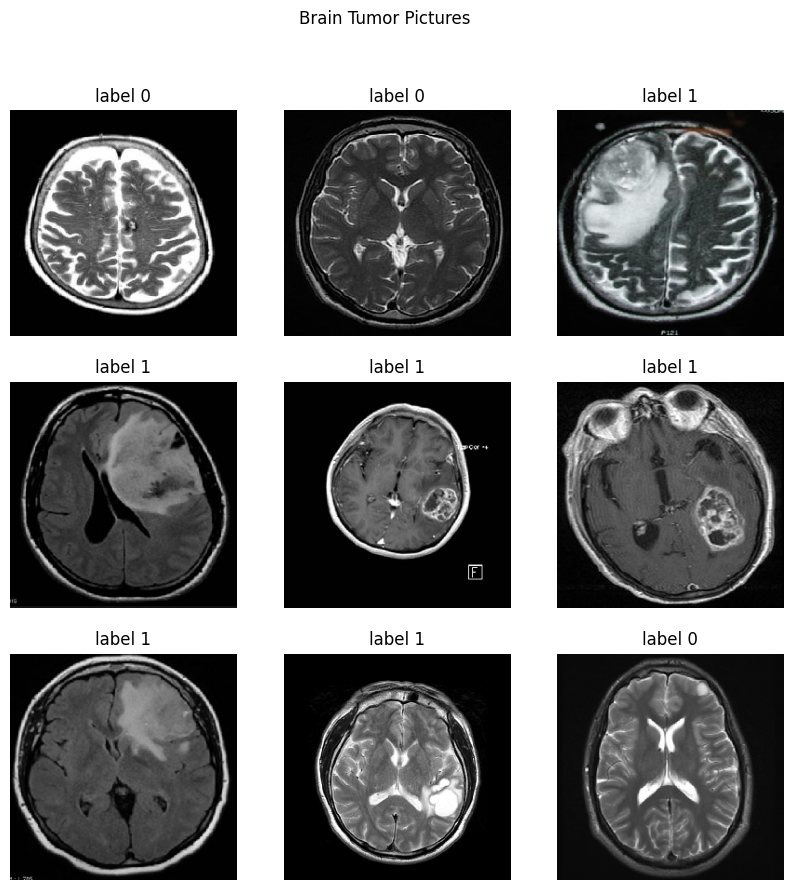

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(10,10))
fig.suptitle("Brain Tumor Pictures")

for k in range(9):
    images, labels = train_ds.next()
    #print(images[0].shape)
    i, j = k//3, k%3
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f"label {int(labels[0])}")
    ax[i, j].axis('off')
plt.show()

1. ResNet50V2

In [ ]:
#CNN Model
#1. ResNET50V2
#Training without data augmentation
from keras.applications import ResNet50V2
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Dropout
from keras.optimizers import Adam
from keras.models import Sequential, load_model


In [ ]:
from keras.src.layers import GlobalAveragePooling1D
base_model=ResNet50V2(input_shape=(244,244,3),include_top=False)
base_model.trainable=False

model1=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256,activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(2, activation='softmax')

])



94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
model1.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                        

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/resnet50v2_best.h5',
                                                monitor='accuracy', verbose=1,
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max",restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history = model1.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 0.5935 - accuracy: 0.7385
Epoch 1: accuracy improved from -inf to 0.73846, saving model to model/resnet50v2_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 19s 805ms/step - loss: 0.5935 - accuracy: 0.7385 - val_loss: 0.3087 - val_accuracy: 0.8750
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8923
Epoch 2: accuracy improved from 0.73846 to 0.89231, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 232ms/step - loss: 0.3124 - accuracy: 0.8923 - val_loss: 0.3377 - val_accuracy: 0.8958
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.9077
Epoch 3: accuracy improved from 0.89231 to 0.90769, saving model to model/resnet50v2_best.h5
7/7 [==============================] - 2s 282ms/step - loss: 0.2627 - accuracy: 0.9077 - val_loss: 0.5086 - val_accuracy: 0.8333
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8872
Epoch 4: accuracy did not improve from 0.90769
7/7 [==============================] - 1s 143ms/step - loss: 0.2618 - accuracy: 0.8872 - val_loss: 0.35

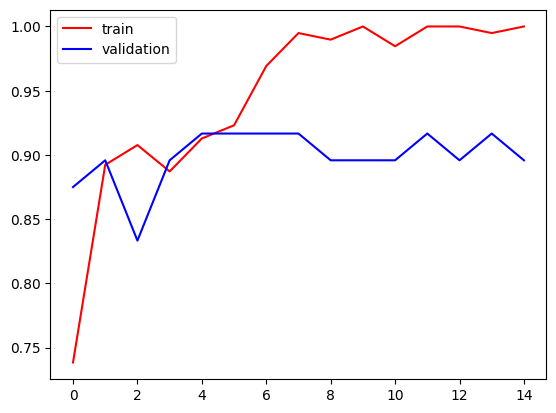

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red', label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

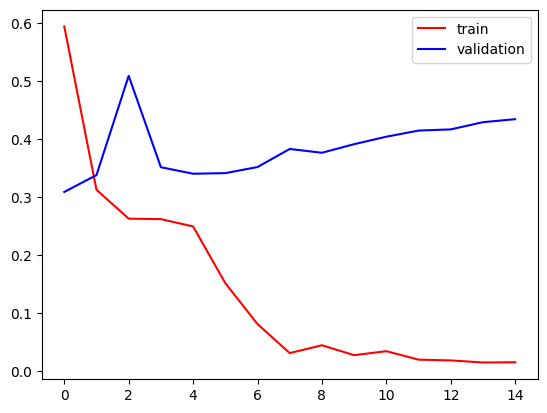

In [ ]:
plt.plot(history.history['loss'],color='red', label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
#augmented_data
aug_train_ds= augmented_data(height,width)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.3,
                                                 patience=2, min_lr=0.0000001)
callbacks_list = [checkpoint,early,reduce_lr]

history = model1.fit(aug_train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks_list)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.3550 - accuracy: 0.8848
Epoch 1: accuracy did not improve from 1.00000
8/8 [==============================] - 7s 905ms/step - loss: 0.3550 - accuracy: 0.8848 - val_loss: 0.5255 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.2127 - accuracy: 0.9095
Epoch 2: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 742ms/step - loss: 0.2127 - accuracy: 0.9095 - val_loss: 0.2237 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.1666 - accuracy: 0.9177
Epoch 3: accuracy did not improve from 1.00000
8/8 [==============================] - 6s 748ms/step - loss: 0.1666 - accuracy: 0.9177 - val_loss: 0.1684 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9300
Epoch 4: accuracy did no

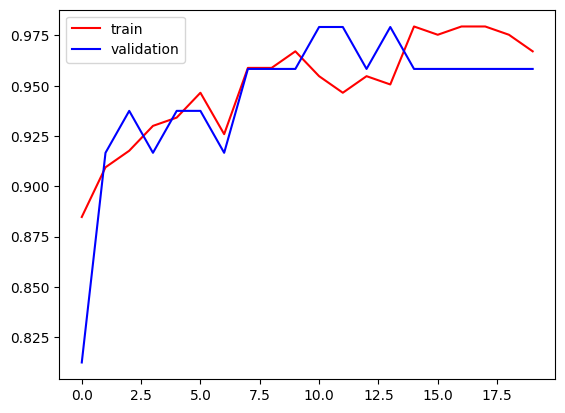

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red', label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

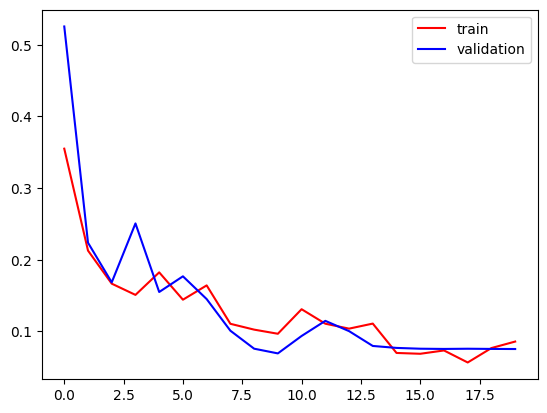

In [ ]:
plt.plot(history.history['loss'],color='red', label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
train_ds_result=n=model1.evaluate(train_ds)
val_ds_result=model1.evaluate(val_ds)
test_ds_result=model1.evaluate(test_ds)

1/1 [==============================] - 1s 862ms/step - loss: 0.0309 - accuracy: 1.0000


In [28]:
model1_result=pd.DataFrame(zip(train_ds_result,val_ds_result,test_ds_result),columns=["train","validation","test"],index=["loss","accuracy"])
model1_result

,train,validation,test
loss,0.019485,0.076877,0.030857
accuracy,0.994872,0.958333,1.000000


In [31]:
y_pred=model1.predict(test_ds[0][0])
y_pred=np.argmax(y_pred,axis=-1)
y_test=test_ds[0][-1]

print("confusion_matrix",confusion_matrix(y_pred,y_test))
print("accuracy_score",accuracy_score(y_test,y_pred))
print("classification_report \n",classification_report(y_test,y_pred))


1/1 [==============================] - 0s 84ms/step
confusion_matrix [[5 0]
 [0 5]]
accuracy_score 1.0
classification_report 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



<Axes: >

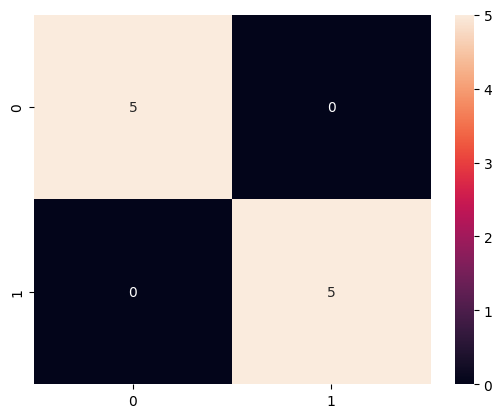

In [34]:
import seaborn as sns
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True)

2.VGG19


In [36]:
from keras.applications.vgg19 import VGG19

In [37]:
height=224
width=224

train_ds,val_ds,test_ds=image_gen(height,width)

base_model=VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(height,width,3)
)

base_model.trainable=False

model2=Sequential([
    base_model,
    Flatten(),
    Dense(1,activation='sigmoid')
])


Found 195 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Found 10 images belonging to 2 classes.
80134624/80134624 [==============================] - 0s 0us/step


In [38]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20049473 (76.48 MB)
Trainable params: 25089 (98.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [39]:
model2.compile(optimizer=Adam(0.01),loss='binary_crossentropy',metrics=['accuracy'])

In [40]:
checkpoint=tf.keras.callbacks.ModelCheckpoint('model/vgg19_best.h5', monitor='accuarcy',verbose=1,mode='max',save_best_only=True)

In [41]:
earlystopping=tf.keras.callbacks.EarlyStopping(monitor='accuracy',mode="max",patience=5,restore_best_weights=True)

In [42]:
callback_list=[checkpoint,earlystopping]

In [44]:
history=model2.fit(train_ds,validation_data=val_ds,epochs=30,shuffle=True,verbose=True,callbacks=callback_list)

Epoch 1/30
7/7 [==============================] - ETA: 0s - loss: 5.6610 - accuracy: 0.4974

7/7 [==============================] - 13s 781ms/step - loss: 5.6610 - accuracy: 0.4974 - val_loss: 2.7024 - val_accuracy: 0.7708
Epoch 2/30
7/7 [==============================] - ETA: 0s - loss: 2.7127 - accuracy: 0.7385

7/7 [==============================] - 1s 196ms/step - loss: 2.7127 - accuracy: 0.7385 - val_loss: 3.8645 - val_accuracy: 0.6667
Epoch 3/30
7/7 [==============================] - ETA: 0s - loss: 2.0036 - accuracy: 0.7641

7/7 [==============================] - 2s 257ms/step - loss: 2.0036 - accuracy: 0.7641 - val_loss: 4.0844 - val_accuracy: 0.7917
Epoch 4/30
7/7 [==============================] - ETA: 0s - loss: 1.8742 - accuracy: 0.8359

7/7 [==============================] - 1s 189ms/step - loss: 1.8742 - accuracy: 0.8359 - val_loss: 2.7261 - val_accuracy: 0.7083
Epoch 5/30
7/7 [==============================] - ETA: 0s - loss: 1.2971 - accuracy: 0.8410

7/7 [==============================] - 1s 192ms/step - loss: 1.2971 - accuracy: 0.8410 - val_loss: 3.2412 - val_accuracy: 0.8125
Epoch 6/30
7/7 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.8872

7/7 [==============================] - 1s 223ms/step - loss: 0.6881 - accuracy: 0.8872 - val_loss: 1.6571 - val_accuracy: 0.7500
Epoch 7/30
7/7 [==============================] - ETA: 0s - loss: 0.4202 - accuracy: 0.9077

7/7 [==============================] - 1s 193ms/step - loss: 0.4202 - accuracy: 0.9077 - val_loss: 1.9976 - val_accuracy: 0.8333
Epoch 8/30
7/7 [==============================] - ETA: 0s - loss: 0.1460 - accuracy: 0.9436

7/7 [==============================] - 1s 228ms/step - loss: 0.1460 - accuracy: 0.9436 - val_loss: 1.1851 - val_accuracy: 0.7917
Epoch 9/30
6/7 [========================>.....] - ETA: 0s - loss: 0.1141 - accuracy: 0.9688

7/7 [==============================] - 1s 193ms/step - loss: 0.1123 - accuracy: 0.9692 - val_loss: 1.5125 - val_accuracy: 0.8333
Epoch 10/30
7/7 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 0.9846

7/7 [==============================] - 1s 194ms/step - loss: 0.0263 - accuracy: 0.9846 - val_loss: 1.1187 - val_accuracy: 0.8542
Epoch 11/30
7/7 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9949

7/7 [==============================] - 1s 198ms/step - loss: 0.0177 - accuracy: 0.9949 - val_loss: 1.2977 - val_accuracy: 0.8333
Epoch 12/30
7/7 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 1.0000

7/7 [==============================] - 1s 196ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 1.3464 - val_accuracy: 0.8333
Epoch 13/30
7/7 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

7/7 [==============================] - 1s 212ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 1.2549 - val_accuracy: 0.8542
Epoch 14/30
7/7 [==============================] - ETA: 0s - loss: 0.0029 - accuracy: 1.0000

7/7 [==============================] - 1s 187ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 1.2778 - val_accuracy: 0.8542
Epoch 15/30
6/7 [========================>.....] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

7/7 [==============================] - 1s 188ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3427 - val_accuracy: 0.8333
Epoch 16/30
7/7 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

7/7 [==============================] - 1s 186ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.3501 - val_accuracy: 0.8333
Epoch 17/30
7/7 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

7/7 [==============================] - 2s 260ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.3150 - val_accuracy: 0.8333


[]

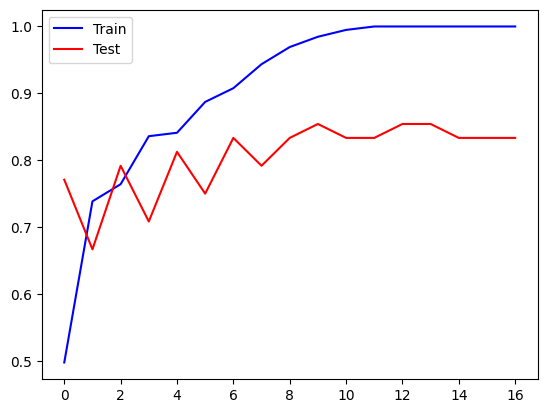

In [45]:
plt.plot(history.history['accuracy'],color='blue',label='Train')
plt.plot(history.history['val_accuracy'],color='red',label='Test')
plt.legend()
plt.plot()


[]

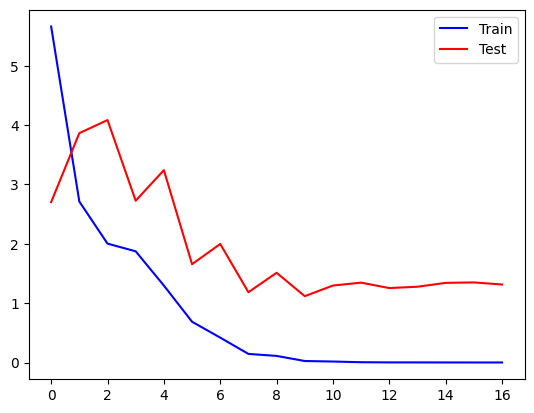

In [46]:
plt.plot(history.history['loss'],color='blue',label='Train')
plt.plot(history.history['val_loss'],color='red',label='Test')
plt.legend()
plt.plot()

In [50]:
#Augmented Data
aug_train_ds=augmented_data(height,width)

reduce_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy',factor=0.3,patience=2,min_lr=0.000001)

callback_list=[checkpoint,earlystopping,reduce_lr]

history=model2.fit(aug_train_ds,validation_data=val_ds,epochs=30,verbose=True,shuffle=True,callbacks=callback_list)

Found 243 images belonging to 2 classes.
Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.7551 - accuracy: 0.8230

8/8 [==============================] - 7s 463ms/step - loss: 0.7551 - accuracy: 0.8230 - val_loss: 1.0586 - val_accuracy: 0.8333 - lr: 0.0100
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.5883 - accuracy: 0.8354

8/8 [==============================] - 5s 601ms/step - loss: 0.5883 - accuracy: 0.8354 - val_loss: 0.6134 - val_accuracy: 0.8333 - lr: 0.0100
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.8313

8/8 [==============================] - 4s 525ms/step - loss: 0.5404 - accuracy: 0.8313 - val_loss: 0.3672 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 4/30
8/8 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8642

8/8 [==============================] - 5s 632ms/step - loss: 0.3858 - accuracy: 0.8642 - val_loss: 0.3199 - val_accuracy: 0.8750 - lr: 0.0100
Epoch 5/30
8/8 [==============================] - ETA: 0s - loss: 0.3809 - accuracy: 0.8807

8/8 [==============================] - 4s 524ms/step - loss: 0.3809 - accuracy: 0.8807 - val_loss: 0.5327 - val_accuracy: 0.8958 - lr: 0.0100
Epoch 6/30
8/8 [==============================] - ETA: 0s - loss: 0.3243 - accuracy: 0.8848

8/8 [==============================] - 9s 1s/step - loss: 0.3243 - accuracy: 0.8848 - val_loss: 0.2630 - val_accuracy: 0.9167 - lr: 0.0100
Epoch 7/30
8/8 [==============================] - ETA: 0s - loss: 0.3444 - accuracy: 0.8889

8/8 [==============================] - 9s 1s/step - loss: 0.3444 - accuracy: 0.8889 - val_loss: 0.1633 - val_accuracy: 0.9375 - lr: 0.0100
Epoch 8/30
8/8 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.8601

8/8 [==============================] - 6s 575ms/step - loss: 0.4546 - accuracy: 0.8601 - val_loss: 0.0463 - val_accuracy: 0.9583 - lr: 0.0100
Epoch 9/30
8/8 [==============================] - ETA: 0s - loss: 0.2390 - accuracy: 0.9177

8/8 [==============================] - 4s 525ms/step - loss: 0.2390 - accuracy: 0.9177 - val_loss: 0.0331 - val_accuracy: 1.0000 - lr: 0.0100
Epoch 10/30
8/8 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.8765

8/8 [==============================] - 7s 961ms/step - loss: 0.4464 - accuracy: 0.8765 - val_loss: 0.0883 - val_accuracy: 0.9583 - lr: 0.0100
Epoch 11/30
8/8 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9177

8/8 [==============================] - 8s 1s/step - loss: 0.2327 - accuracy: 0.9177 - val_loss: 0.0524 - val_accuracy: 0.9792 - lr: 0.0100
Epoch 12/30
8/8 [==============================] - ETA: 0s - loss: 0.1782 - accuracy: 0.9259

8/8 [==============================] - 6s 749ms/step - loss: 0.1782 - accuracy: 0.9259 - val_loss: 0.0365 - val_accuracy: 0.9792 - lr: 0.0030
Epoch 13/30
8/8 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9136

8/8 [==============================] - 9s 909ms/step - loss: 0.1985 - accuracy: 0.9136 - val_loss: 0.0577 - val_accuracy: 0.9792 - lr: 0.0030
Epoch 14/30
8/8 [==============================] - ETA: 0s - loss: 0.1867 - accuracy: 0.9342

8/8 [==============================] - 13s 2s/step - loss: 0.1867 - accuracy: 0.9342 - val_loss: 0.0205 - val_accuracy: 1.0000 - lr: 0.0030
Epoch 15/30
8/8 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9342

8/8 [==============================] - 7s 822ms/step - loss: 0.1234 - accuracy: 0.9342 - val_loss: 0.0404 - val_accuracy: 0.9792 - lr: 0.0030
Epoch 16/30
8/8 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9053

8/8 [==============================] - 7s 841ms/step - loss: 0.2256 - accuracy: 0.9053 - val_loss: 0.0772 - val_accuracy: 0.9792 - lr: 0.0030
Epoch 17/30
8/8 [==============================] - ETA: 0s - loss: 0.2176 - accuracy: 0.9095

8/8 [==============================] - 4s 514ms/step - loss: 0.2176 - accuracy: 0.9095 - val_loss: 0.0143 - val_accuracy: 1.0000 - lr: 9.0000e-04
Epoch 18/30
8/8 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9342

8/8 [==============================] - 7s 905ms/step - loss: 0.1948 - accuracy: 0.9342 - val_loss: 0.0216 - val_accuracy: 0.9792 - lr: 9.0000e-04
Epoch 19/30
8/8 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.9465

8/8 [==============================] - 7s 798ms/step - loss: 0.1338 - accuracy: 0.9465 - val_loss: 0.0456 - val_accuracy: 0.9792 - lr: 2.7000e-04
Epoch 20/30
8/8 [==============================] - ETA: 0s - loss: 0.1483 - accuracy: 0.9465

8/8 [==============================] - 9s 1s/step - loss: 0.1483 - accuracy: 0.9465 - val_loss: 0.0321 - val_accuracy: 0.9792 - lr: 2.7000e-04
Epoch 21/30
8/8 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9547

8/8 [==============================] - 10s 1s/step - loss: 0.1103 - accuracy: 0.9547 - val_loss: 0.0177 - val_accuracy: 1.0000 - lr: 2.7000e-04
Epoch 22/30
8/8 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.9342

8/8 [==============================] - 7s 908ms/step - loss: 0.1480 - accuracy: 0.9342 - val_loss: 0.0165 - val_accuracy: 1.0000 - lr: 2.7000e-04
Epoch 23/30
8/8 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9506

8/8 [==============================] - 11s 1s/step - loss: 0.1275 - accuracy: 0.9506 - val_loss: 0.0212 - val_accuracy: 1.0000 - lr: 2.7000e-04
Epoch 24/30
8/8 [==============================] - ETA: 0s - loss: 0.1192 - accuracy: 0.9506

8/8 [==============================] - 10s 1s/step - loss: 0.1192 - accuracy: 0.9506 - val_loss: 0.0234 - val_accuracy: 0.9792 - lr: 8.1000e-05
Epoch 25/30
8/8 [==============================] - ETA: 0s - loss: 0.1572 - accuracy: 0.9259

8/8 [==============================] - 7s 828ms/step - loss: 0.1572 - accuracy: 0.9259 - val_loss: 0.0228 - val_accuracy: 1.0000 - lr: 8.1000e-05
Epoch 26/30
8/8 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9712

8/8 [==============================] - 6s 799ms/step - loss: 0.0810 - accuracy: 0.9712 - val_loss: 0.0231 - val_accuracy: 1.0000 - lr: 2.4300e-05
Epoch 27/30
8/8 [==============================] - ETA: 0s - loss: 0.1032 - accuracy: 0.9588

8/8 [==============================] - 8s 856ms/step - loss: 0.1032 - accuracy: 0.9588 - val_loss: 0.0232 - val_accuracy: 0.9792 - lr: 2.4300e-05
Epoch 28/30
8/8 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.9506

8/8 [==============================] - 4s 554ms/step - loss: 0.1130 - accuracy: 0.9506 - val_loss: 0.0235 - val_accuracy: 0.9792 - lr: 2.4300e-05
Epoch 29/30
8/8 [==============================] - ETA: 0s - loss: 0.1342 - accuracy: 0.9424

8/8 [==============================] - 5s 623ms/step - loss: 0.1342 - accuracy: 0.9424 - val_loss: 0.0233 - val_accuracy: 0.9792 - lr: 7.2900e-06
Epoch 30/30
8/8 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.9259

8/8 [==============================] - 4s 516ms/step - loss: 0.1568 - accuracy: 0.9259 - val_loss: 0.0232 - val_accuracy: 1.0000 - lr: 7.2900e-06


[]

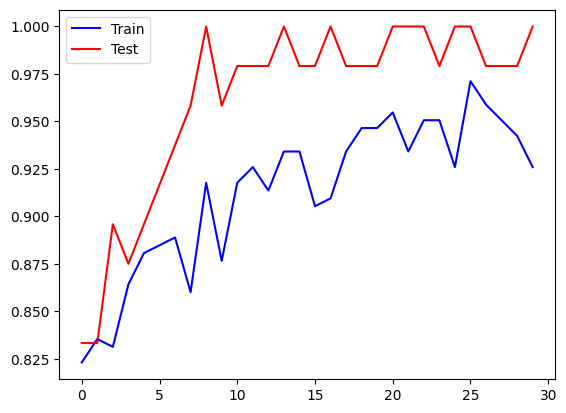

In [51]:
plt.plot(history.history['accuracy'],color='blue',label='Train')
plt.plot(history.history['val_accuracy'],color='red',label='Test')
plt.legend()
plt.plot()

[]

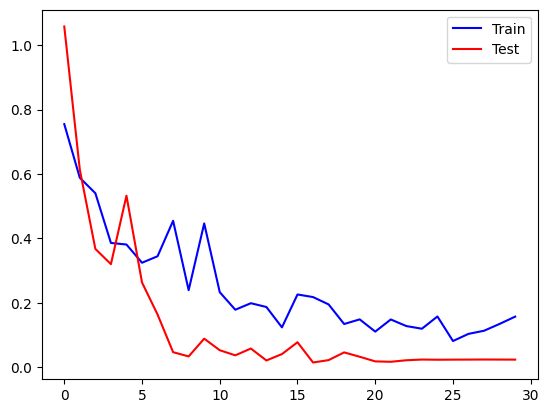

In [52]:
plt.plot(history.history['loss'],color='blue',label='Train')
plt.plot(history.history['val_loss'],color='red',label='Test')
plt.legend()
plt.plot()

In [56]:
train_ds_result=model2.evaluate(train_ds)
val_ds_result=model2.evaluate(val_ds)
test_ds_result=model2.evaluate(test_ds)

model2_result=pd.DataFrame(zip(train_ds_result,val_ds_result,test_ds_result),columns=['Train','val','Test'],index=['loss','acuarcy'])

model2_result

1/1 [==============================] - 0s 141ms/step - loss: 0.1661 - accuracy: 0.9000


,Train,val,Test
loss,0.008861,0.023163,0.166108
acuarcy,0.994872,1.000000,0.900000


In [54]:
y_pred = model2.predict(test_ds[0][0])
y_pred = np.array([1 if x > 0.5 else 0 for x in y_pred])

y_test = test_ds[0][-1]

#print(y_pred.shape)
#print(y_test.shape)
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score: ", accuracy_score(y_test,y_pred))
print("Classification report:\n", classification_report(y_pred,y_test))

1/1 [==============================] - 0s 490ms/step
Confusion matrix:
 [[5 0]
 [1 4]]
Accuracy Score:  0.9
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.80      1.00      0.89         4

    accuracy                           0.90        10
   macro avg       0.90      0.92      0.90        10
weighted avg       0.92      0.90      0.90        10



<Axes: >

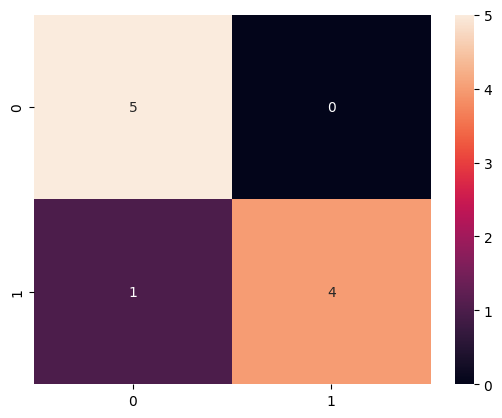

In [55]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)